In [ ]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg
import cv2
from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive')

import pandas as pd
import tensorflow as tf
import keras as keras
from keras import layers

from skimage.util import random_noise
from skimage.filters import threshold_multiotsu

In [ ]:
# function to add Gaussian noise to image
def addNoise(img, noiseFactor):
  h = len(img)
  w = len(img[0])
  noise_img = 255*random_noise(img, mode='s&p',amount=noiseFactor)
  return noise_img

In [ ]:
def preprocess(img, noise=False, noiseFactor=None):
  
  # Add Median Blur
  #img = cv2.medianBlur(img, 7)
  
  # Sharpen Image
  #kernel = np.array([[0,-2,0], 
  #                 [-2,10,-2], 
  #                 [0,-2,0]]) 
  #img = cv2.filter2D(img, -1, kernel)
  #img = img.astype("uint8")

  # Convert to Grayscale
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  # Add Noise if desired
  #if noise != False:
  #  img = noiseToImg(img, noise)
  if noise: img = addNoise(img, noiseFactor)
  img = img.astype("uint8")

  # Binarization
  #th3, img = cv2.threshold(img,0,255,cv2.THRESH_OTSU+cv2.THRESH_BINARY)
  return img

In [ ]:
#def preprocess(img, noise=False, noiseFactor=None):
  
  # Sharpen Image
  #kernel = np.array([[0,-2,0], 
  #                 [-2,10,-2], 
  #                 [0,-2,0]]) 
  #img = cv2.filter2D(img, -1, kernel/5)
  #img = img.astype("uint8")

  # Add Median Blur
  #img = cv2.medianBlur(img, 3)

  # Add Noise if desired
  #if noise != False:
  #  img = noiseToImg(img, noise)
  #hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  #h,s,v = cv2.split(hsv_img)
  #hsv_split = np.concatenate((h,s,v),axis=1)

  #thresholds = threshold_multiotsu(v, classes=2)
  #if noise: v = addNoise(v, noiseFactor)
  # Using the threshold values, we generate the three regions.
  #regions = np.digitize(v, bins=thresholds)
  
  #regions = regions.astype("uint8")

  #return regions

In [ ]:
def cutImageUp(img, w, h):
  rowRange = range(0, len(img)//w * w, w)
  colRange = range(0, len(img[0])//h * h, h)
  cutup = np.zeros(((len(rowRange)) * (len(colRange)), w, h, 1))
  index = 0
  for (ri, i) in enumerate(rowRange):
    for (ci, j) in enumerate(colRange):
      cutup[index] = np.reshape(img[i : (i + w), j : (j + h)], (w, h, 1))
      index = index + 1
  return cutup

In [ ]:
def stitchTogether(cutImg, w, h):
  dim = cutImg[0].shape
  w_i, h_i = dim[0], dim[1]
  n = len(cutImg)

  rangeW = w // w_i
  rangeH = h // h_i

  img_lst = []

  cnt = 0
  for j in range(0, rangeH):
    lst = []
    for i in range(0, rangeW):
      if cnt >= n:
         return cv2.vconcat(img_lst)
      lst.append(cutImg[cnt])
      cnt += 1
    img_lst.append(cv2.hconcat(lst))



  return cv2.vconcat(img_lst)

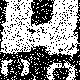

In [ ]:
folder = "/content/drive/MyDrive/ENEE 439D Final Project/Aerospace PCB Our Pics"
n = 50*31
train = np.zeros((n, 80, 80, 1))
test = np.zeros((n, 80, 80, 1))
test2 = np.zeros((n, 80, 80, 1))
for i in range(n):

  trainImg = cv2.imread(folder + "/defect_processed_cropped/" + str((i%31)+1) + ".jpg")
  trainImg[trainImg < 255/2] = 0
  trainImg[trainImg > 255/2] = 255
  testImg = cv2.imread(folder + "/nodefect_processed_cropped/" + str((i%31)+1) + ".jpg")
  testImg[testImg < 255/2] = 0
  testImg[testImg > 255/2] = 255

  defect = preprocess(trainImg, noise = True, noiseFactor = 0.3)
  #defect = cutImageUp(img, 80, 80)[0]/255.
  #defect = defect.astype('uint8')
  train[i] = np.reshape(defect, (80, 80, 1))/255.
  #test2[i] = np.reshape(defect, (80, 80, 1))/255.


  nodefect = preprocess(testImg, noise = True, noiseFactor = 0)
  #nodefect = cutImageUp(img, 80, 80)[0]/255.
  #nodefect = nodefect.astype('uint8')
  test[i] = np.reshape(nodefect, (80, 80, 1))/255.

cv2_imshow(train[0]*255)

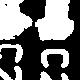

In [ ]:
cv2_imshow(test[0]*255)

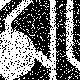

(3550, 80, 80, 1) (3550, 80, 80, 1)


In [ ]:
def deep_pcb_preprocess(img, noise = False, noiseFactor = 0.0):
  # Convert to Grayscale
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  # Add Noise if desired
  #if noise != False:
  #  img = noiseToImg(img, noise)
  if noise: img = addNoise(img, noiseFactor)
  #img = img.astype("uint8")

  return img
# better approach to try -- isolate only defective regions -- not all -- also sample out randomly on images
# adding in deep pcb data
deep_pcb_root = "/content/drive/MyDrive/ENEE 439D Final Project/Deep PCB Data"
n = 2000
deep_train = np.zeros((n, 80, 80, 1))
deep_test = np.zeros((n, 80, 80, 1))
filenames = [file[:-9] for file in os.listdir(deep_pcb_root + "/Test")]
i = 0
for file_id in filenames*10:

  if i < n:
    trainImg = cv2.imread(deep_pcb_root + "/Test/" + file_id + "_test.jpg")
    testImg = cv2.imread(deep_pcb_root + "/Template/" + file_id + "_temp.jpg")

    img = deep_pcb_preprocess(trainImg, noise = True, noiseFactor = 0.3)
    defect = cutImageUp(img, 80, 80)[0]/255.
    
    defect[defect < 0.5] = 0
    defect[defect > 0.5] = 1
    defect = defect.astype('uint8')
    deep_train[i] = np.reshape(defect, (80, 80, 1))

    img = deep_pcb_preprocess(testImg, noise = True, noiseFactor = 0.0)
    nodefect = cutImageUp(img, 80, 80)[0]/255.
    
    nodefect[nodefect < 0.5] = 0
    nodefect[nodefect > 0.5] = 1
    nodefect = nodefect.astype('uint8')
    deep_test[i] = np.reshape(nodefect, (80, 80, 1))

    i += 1

cv2_imshow(deep_train[0]*255)

# combine data
train = np.concatenate((train, deep_train))
test = np.concatenate((test, deep_test))

from sklearn.utils import shuffle
train, test = shuffle(train, test, random_state=0)
print(train.shape, test.shape)

In [ ]:
np.shape(train[0])

(80, 80, 1)

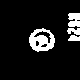

In [ ]:
cv2_imshow(test[0]*255)

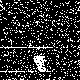

In [ ]:
cv2_imshow(np.abs(np.subtract(test[1], train[1]))*255)

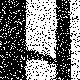

In [ ]:
cv2_imshow(train[-3]*255)

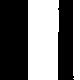

In [ ]:
cv2_imshow(test[-3]*255)

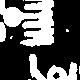

In [ ]:
cv2_imshow(test[-49]*255)

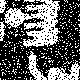

In [ ]:
cv2_imshow(train[-49]*255)

In [ ]:
input_img = keras.Input(shape = (80, 80, 1))
encoded_1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
encoded_1 = layers.MaxPooling2D((2, 2), padding='same')(encoded_1) # 200x200
encoded_2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_1)
encoded_2 = layers.MaxPooling2D((2, 2), padding='same')(encoded_2) # 100x100
encoded_3 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_2)
encoded_3 = layers.MaxPooling2D((2, 2), padding='same')(encoded_3) # 50x50


decoded_1 = layers.Conv2D(16, (3, 3), activation='relu', padding = 'same')(encoded_3) #50x50
decoded_1 = keras.layers.Add()([decoded_1, encoded_3]) # skip connection
decoded_1 = layers.UpSampling2D((2, 2))(decoded_1) #100x100
decoded_2 = layers.Conv2D(32, (3, 3), activation='relu', padding = 'same')(decoded_1)
decoded_2 = keras.layers.Add()([decoded_2, encoded_2]) # skip connection
decoded_2 = layers.UpSampling2D((2, 2))(decoded_2) #200x200
decoded_3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(decoded_2)
decoded_3 = keras.layers.Add()([decoded_3, encoded_1])
decoded_3 = layers.UpSampling2D((2, 2))(decoded_3)
autoencoder = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(decoded_3)

nodefect_autoencoder = keras.Model(input_img, autoencoder)
nodefect_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                             loss='binary_crossentropy',  metrics=["accuracy", 'mse'])
nodefect_autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 64)   640         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 40, 40, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 40, 40, 32)   18464       ['max_pooling2d[0][0]']          
                                                                                              

In [ ]:
input_img = keras.Input(shape = (80, 80, 1))
encoded_1 = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
encoded_1 = layers.MaxPooling2D((2, 2), padding='same')(encoded_1) # 200x200
encoded_2 = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_1)
encoded_2 = layers.MaxPooling2D((2, 2), padding='same')(encoded_2) # 200x200
encoded_3 = layers.Conv2D(8, (5, 5), activation='relu', padding='same')(encoded_2)
encoded_3 = layers.MaxPooling2D((2, 2), padding='same')(encoded_3) # 100x100
encoded_4 = layers.Conv2D(4, (5, 5), activation='relu', padding='same')(encoded_3)
encoded_4 = layers.MaxPooling2D((2, 2), padding='same')(encoded_4) # 50x50


decoded_1 = layers.Conv2D(4, (5, 5), activation='relu', padding = 'same')(encoded_4) #50x50
decoded_1 = keras.layers.Add()([decoded_1, encoded_4]) # skip connection
decoded_1 = layers.UpSampling2D((2, 2))(decoded_1) #100x100
decoded_2 = layers.Conv2D(8, (5, 5), activation='relu', padding = 'same')(decoded_1)
decoded_2 = keras.layers.Add()([decoded_2, encoded_3]) # skip connection
decoded_2 = layers.UpSampling2D((2, 2))(decoded_2) #200x200
decoded_3 = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(decoded_2)
decoded_3 = keras.layers.Add()([decoded_3, encoded_2])
decoded_3 = layers.UpSampling2D((2, 2))(decoded_3)

decoded_4 = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_3)
decoded_4 = keras.layers.Add()([decoded_4, encoded_1])
decoded_4 = layers.UpSampling2D((2, 2))(decoded_4)
autoencoder = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(decoded_4)

nodefect_autoencoder = keras.Model(input_img, autoencoder)
nodefect_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(),
                             loss='mse',  metrics=["accuracy", 'mse'])
nodefect_autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 80, 80, 1)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 80, 80, 32)   832         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 40, 40, 32)  0           ['conv2d_7[0][0]']               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 40, 40, 16)   12816       ['max_pooling2d_3[0][0]']        
                                                                                            

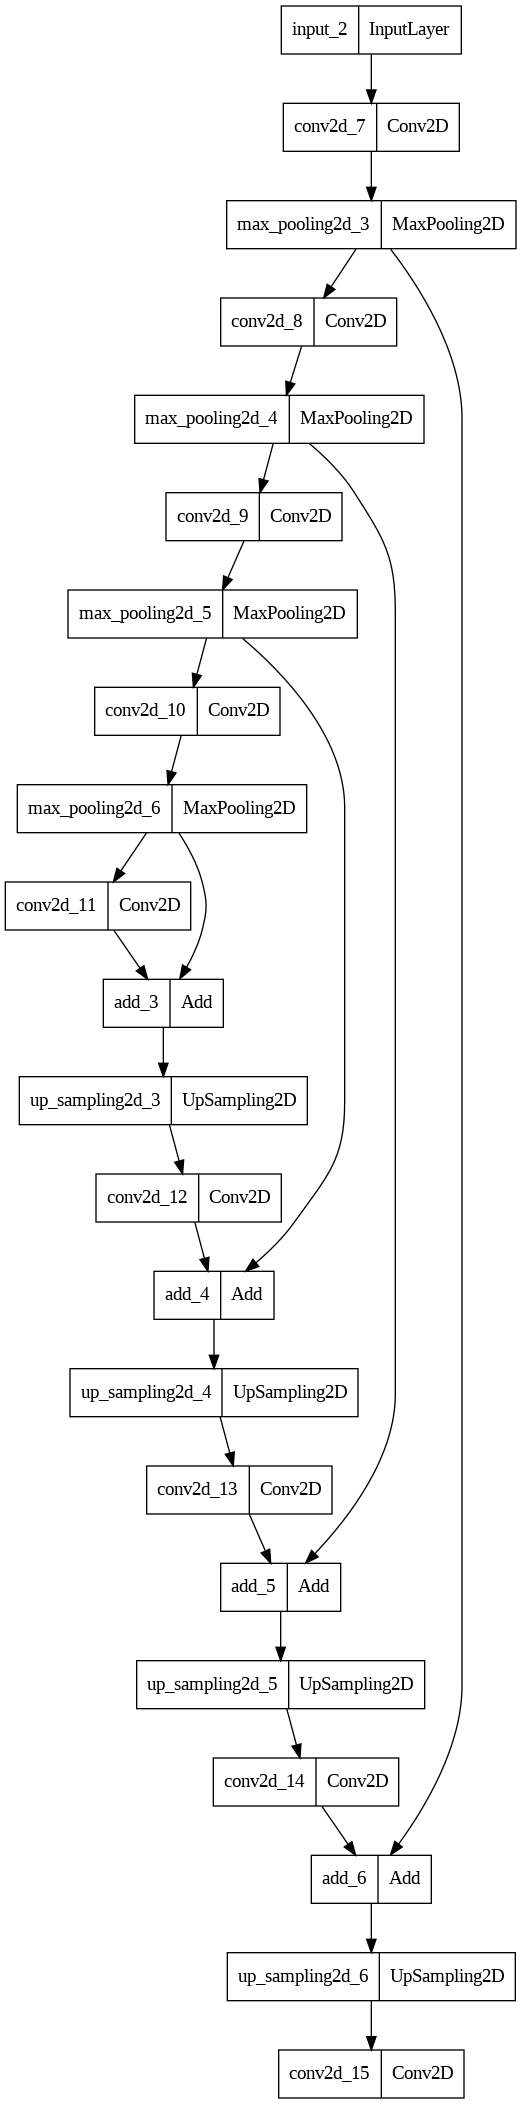

In [ ]:
tf.keras.utils.plot_model(nodefect_autoencoder)

In [ ]:
history = nodefect_autoencoder.fit(train, test, epochs=200, verbose=1, validation_split = 0.1)

Epoch 1/200
100/100 [==============================] - 15s 20ms/step - loss: 0.0957 - accuracy: 0.8750 - mse: 0.0957 - val_loss: 0.0853 - val_accuracy: 0.8857 - val_mse: 0.0853
Epoch 2/200
100/100 [==============================] - 1s 11ms/step - loss: 0.0811 - accuracy: 0.8909 - mse: 0.0811 - val_loss: 0.0843 - val_accuracy: 0.8861 - val_mse: 0.0843
Epoch 3/200
100/100 [==============================] - 1s 14ms/step - loss: 0.0780 - accuracy: 0.8946 - mse: 0.0780 - val_loss: 0.0784 - val_accuracy: 0.8935 - val_mse: 0.0784
Epoch 4/200
100/100 [==============================] - 1s 14ms/step - loss: 0.0735 - accuracy: 0.8998 - mse: 0.0735 - val_loss: 0.0743 - val_accuracy: 0.8983 - val_mse: 0.0743
Epoch 5/200
100/100 [==============================] - 1s 12ms/step - loss: 0.0699 - accuracy: 0.9044 - mse: 0.0699 - val_loss: 0.0713 - val_accuracy: 0.9021 - val_mse: 0.0713
Epoch 6/200
100/100 [==============================] - 1s 11ms/step - loss: 0.0669 - accuracy: 0.9086 - mse: 0.0669 - v

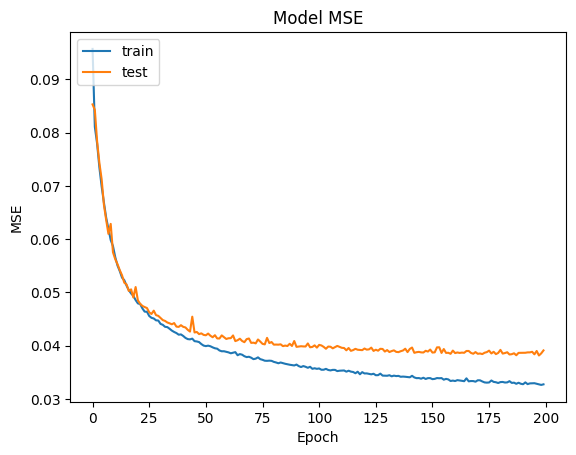

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

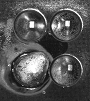

In [ ]:
p = cv2.imread("/content/drive/MyDrive/ENEE 439D Final Project/PCB_DATASET/reconstruct/defect/3.png")
p = preprocess(p)
cv2_imshow(p)

1/1 [==============================] - 0s 351ms/step


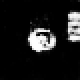

In [ ]:
#img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/459DNotebooks/Layout_Imgs/testDefect/1.png")
#img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)/255.
#img = preprocess(img)
#img = img/255.
#cutup = cutImageUp(img, 400, 400)
input = np.reshape(train[0], (1, 80, 80, 1))
prediction = nodefect_autoencoder.predict(input, verbose=1)
#decoded = stitchTogether(prediction, len(img), len(img[0]))
cv2_imshow(prediction[0]*255)
#cv2.imwrite("/content/drive/MyDrive/Colab Notebooks/459DNotebooks/nodefect_autoencoder_defect_img.png", decoded)

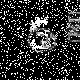

In [ ]:
cv2_imshow(np.abs(np.subtract(train[0], prediction[0])) * 255)

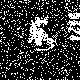

In [ ]:
cv2_imshow(train[0]*255)

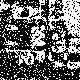

In [ ]:
cv2_imshow(train[17]*255)

In [ ]:
img = cv2.imread("/content/drive/MyDrive/ENEE 439D Final Project/PCB_DATASET/reconstruct/test2.png")
#img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)/255.
#img = preprocess(img)
img1 = img1/255.
cutup = cutImageUp(p/255., 80, 80)
input = cutup
prediction = nodefect_autoencoder.predict(input, verbose=1)
#decoded = stitchTogether(prediction, len(img), len(img[0]))
cv2_imshow(prediction[0]*255)
#cv2.imwrite("/content/drive/MyDrive/Colab Notebooks/459DNotebooks/nodefect_autoencoder_defect_img.png", decoded)

NameError: ignored

In [ ]:
cv2_imshow(input[0]*255)

In [ ]:
cv2_imshow(np.abs((prediction[0] - input[0]))*255)

In [ ]:
cv2_imshow(np.abs((prediction[0] - cutup[0]))*255)

In [ ]:
#from keras.backend import dtype
def classify_deep_pcb(file_path):
  img = cv2.imread(file_path)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img = img.astype("uint8")
  cv2_imshow(img)
  img = img/255.
  cutup = cutImageUp(img, 80, 80)
  prediction = nodefect_autoencoder.predict(cutup, verbose=1)






  #cv2_imshow(np.abs((prediction[0] - cutup[0]))*255)

  # more intrecate maskign algorithm
  # prediction = [(arr * 255).astype('uint8') for arr in prediction]
  # cutup = [(arr * 255).astype('uint8') for arr in cutup]
  cv2_imshow(prediction[0] * 255)
  cv2_imshow(cutup[0] * 255)
  difference = np.subtract(cutup[0], prediction[0]) * 255
  cv2_imshow(difference)
  
  
  
  # prediction = [arr.astype('uint8') for arr in prediction]
  # cutup = [arr.astype('uint8') for arr in cutup]
  # prediction = [cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_32F) for img in prediction]
  # cutup = [cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_32F) for img in cutup]

  # prediction = [arr.astype('uint8') for arr in prediction]
  # cutup = [arr.astype('uint8') for arr in cutup]
  
  # prediction = [cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) for gray in prediction]
  # cutup = [cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) for gray in cutup]

  # cv2_imshow(prediction[0])

  #print(cutup[0].dtype, prediction[0].dtype)
  # difference = cv2.subtract(prediction[0], cutup[0], dtype=cv2.CV_64F)
  # difference = cv2.normalize(difference, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_64F)
  # cv2_imshow(difference)

  # #print(difference.shape)
  # Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
  # ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  # difference[mask != 255] = [0, 0, 255]
  # prediction[0][mask != 255] = [0, 0, 255]
  # cv2_imshow(prediction[0])
  # return difference


im_test = cv2.imread('/content/drive/MyDrive/ENEE 439D Final Project/Deep PCB Data/Test/  _test.jpg')
im_temp = cv2.imread('/content/drive/MyDrive/ENEE 439D Final Project/Deep PCB Data/Template/000410000_temp.jpg')
difference = classify_deep_pcb('/content/drive/MyDrive/ENEE 439D Final Project/Deep PCB Data/Test/000410000_test.jpg')


In [ ]:
def preprocess(img, noise=False, noiseFactor=None):
  
  # Sharpen Image
  kernel = np.array([[0,-2,0], 
                   [-2,10,-2], 
                   [0,-2,0]]) 
  #img = cv2.filter2D(img, -1, kernel/5)
  #img = img.astype("uint8")

  # Add Median Blur
  #img = cv2.medianBlur(img, 3)

  # Add Noise if desired
  #if noise != False:
  #  img = noiseToImg(img, noise)
  hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  h,s,v = cv2.split(hsv_img)
  hsv_split = np.concatenate((h,s,v),axis=1)

  thresholds = threshold_multiotsu(v, classes=2)
  if noise: v = addNoise(v, noiseFactor)
  # Using the threshold values, we generate the three regions.
  regions = np.digitize(v, bins=thresholds)
  
  #regions = regions.astype("uint8")

  return regions

In [ ]:
np.shape(train)

In [ ]:
def classify_regular_pcb(file_path):
  img = cv2.imread(file_path)
  img = preprocess(img)
  cv2_imshow(img*255)
  cutup = cutImageUp(img, 80, 80)
  prediction = nodefect_autoencoder.predict(cutup, verbose=1)

  cv2_imshow(prediction[0] * 255)
  cv2_imshow(cutup[0] * 255)
  difference = np.subtract(cutup[0], prediction[0]) * 255
  cv2_imshow(difference)
  

In [ ]:
classify_regular_pcb("/content/drive/MyDrive/ENEE 439D Final Project/Aerospace PCB Our Pics/defect_cropped/12.JPG")

In [ ]:
classify_regular_pcb("/content/drive/MyDrive/ENEE 439D Final Project/Aerospace PCB Our Pics/defectback4.jpg")

In [ ]:
nodefect_autoencoder.save('/content/drive/MyDrive/ENEE 439D Final Project/Aerospace PCB Our Pics/nodefectReconstruct')

# Takeaways adding deep pcb 

- Core idea seems to work -- it does generate the defect
- issue: interpolation of image scaling causing noise issues
- inital image is white with black background -- is this what we want?